# SKM human ageing dataset: hindlimb in old (19 m/o) and young (3 m/o) mice 

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import gseapy
import matplotlib.pyplot as plt
import warnings
import os
import urllib.request

### Pre-proc 

In [37]:
# Load the data
dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/human_SKM_ageing_atlas_2024"
mice_hindlimb_anndata = os.path.join(dir, "mice_hindlimb.h5ad")
adata = sc.read_h5ad(mice_hindlimb_anndata)
adata



AnnData object with n_obs × n_vars = 96529 × 15721
    obs: 'SampleID', 'Age_bin', 'annotation', 'n_counts', 'n_genes', 'mito_per', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'GeneID', 'feature_types', 'GeneName', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'

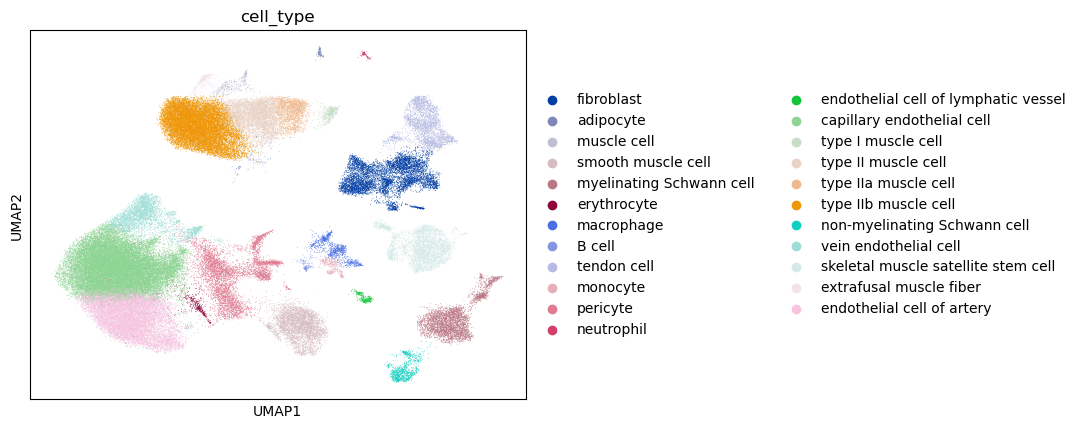

In [4]:
# plot the data
sc.pl.umap(adata, color = "cell_type")

#### Select the cell types of myofibers

/ocean/projects/cis240075p/asachan/.conda/envs/czi/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


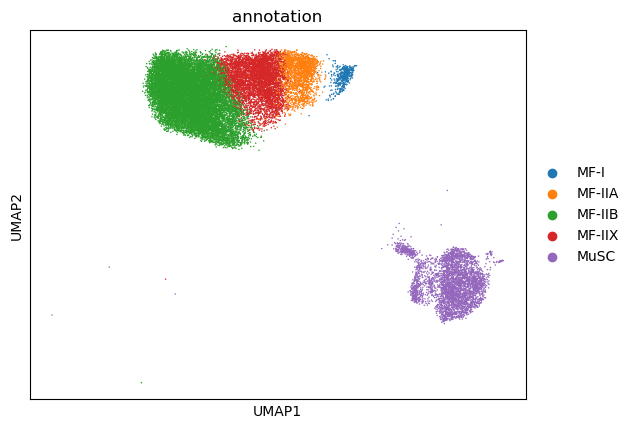

In [5]:
# subset the anndata to have only cell types of myofibers
myofiber_adata = adata[adata.obs["cell_type"].isin(["skeletal muscle satellite stem cell", "type II muscle cell", "type IIa muscle cell", "type IIb muscle cell", "type I muscle cell"])]
myofiber_adata

# plot the data
sc.pl.umap(myofiber_adata, color = "annotation")

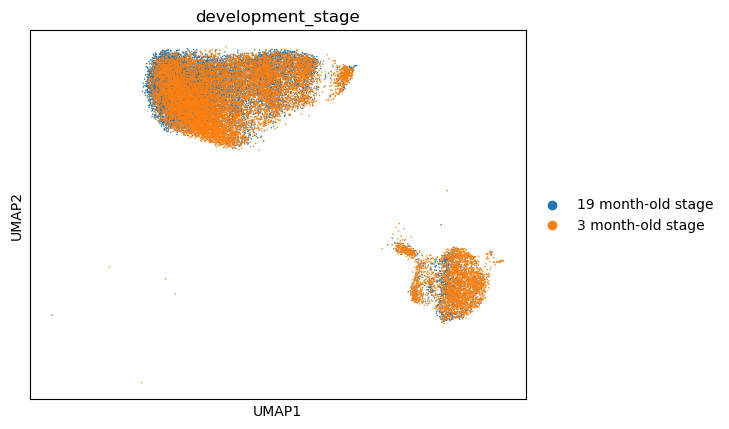

In [6]:
# plot development stage
sc.pl.umap(myofiber_adata, color = "development_stage")

In [7]:
myofiber_adata.var_names


Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000025900',
       'ENSMUSG00000025902', 'ENSMUSG00000033845', 'ENSMUSG00000104217',
       'ENSMUSG00000033813', 'ENSMUSG00000002459', 'ENSMUSG00000033793',
       'ENSMUSG00000025907',
       ...
       'ENSMUSG00000064358', 'ENSMUSG00000064360', 'ENSMUSG00000065947',
       'ENSMUSG00000064363', 'ENSMUSG00000064367', 'ENSMUSG00000064368',
       'ENSMUSG00000064370', 'ENSMUSG00000062783', 'ENSMUSG00000079800',
       'ENSMUSG00000095041'],
      dtype='object', name='GeneID', length=15721)

In [24]:
# use utils function to map ensembl to gene name
from utils import map_ensembl_to_gene_name
myofiber_adata = map_ensembl_to_gene_name(myofiber_adata, gtf_file_path = "/ocean/projects/cis240075p/asachan/datasets/mouse_genome_files/refdata-gex-mm10-2020-A/genes/genes.gtf")

In [23]:
print(myofiber_adata.var_names)
print(myofiber_adata.var.index)



Index(['Xkr4', 'Gm1992', 'Rp1', 'Sox17', 'Mrpl15', 'ENSMUSG00000104217',
       'Tcea1', 'Rgs20', 'Atp6v1h', 'Rb1cc1',
       ...
       'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb',
       'Csprs', 'AC125149.3', 'AC149090.1'],
      dtype='object', length=15721)
Index(['Xkr4', 'Gm1992', 'Rp1', 'Sox17', 'Mrpl15', 'ENSMUSG00000104217',
       'Tcea1', 'Rgs20', 'Atp6v1h', 'Rb1cc1',
       ...
       'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb',
       'Csprs', 'AC125149.3', 'AC149090.1'],
      dtype='object', length=15721)


In [38]:
# save the anndata object
myofiber_adata.write(os.path.join(dir, "myofiber_adata.h5ad"))


## DEGs between 19 m/o and 3 m/o mice
#### Use scvi.model.SCVI.differential_expression function to calculate DEGs between a particular cluster and the reference using the Bayesian approach

In [44]:
# load the anndata object
myofiber_adata = sc.read_h5ad(os.path.join(dir, "myofiber_adata.h5ad"))
myofiber_adata


AnnData object with n_obs × n_vars = 26385 × 15721
    obs: 'SampleID', 'Age_bin', 'annotation', 'n_counts', 'n_genes', 'mito_per', 'scrublet_score', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'GeneID', 'feature_types', 'GeneName', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'annotation_colors', 'cell_type_colors', 'citation', 'default_embedding', 'development_stage_colors', 'rank_genes_groups', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_scVI', 'X_umap'

In [45]:
myofiber_adata.var["GeneName"]

Xkr4                Xkr4
Gm1992            Gm1992
Rp1                  Rp1
Sox17              Sox17
Mrpl15            Mrpl15
                 ...    
mt-Nd6            mt-Nd6
mt-Cytb          mt-Cytb
Csprs              Csprs
AC125149.3    AC125149.3
AC149090.1          PISD
Name: GeneName, Length: 15721, dtype: object

In [40]:
print(myofiber_adata.X.shape)
print(myofiber_adata.X.max())
print(myofiber_adata.X.min())
print(myofiber_adata.X.mean())

(26385, 15721)
8.493203
0.0
0.09277928


#### Check SERCA1,2 expression in myofibers

In [46]:
# find the gene names atp
myofiber_adata.var_names[myofiber_adata.var_names.str.contains("Atp2a")]

Index(['Atp2a2', 'Atp2a1', 'Atp2a3'], dtype='object')

#### Make scanpy select gene names instead of ensembl ids

KeyError: 'Atp2a1'

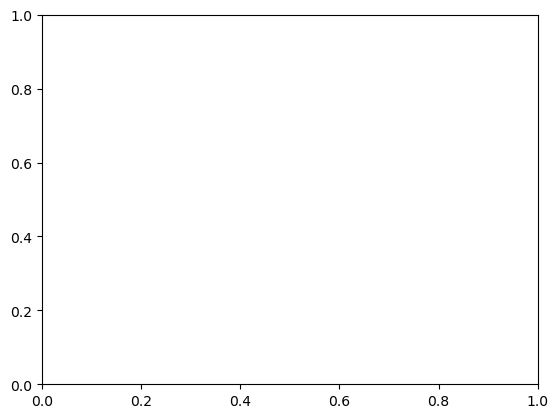

In [47]:
# plot atp2a1 in umap
sc.pl.umap(myofiber_adata, color = ["Atp2a1"])